# **Textual Data Analysis - Exercise - 4**


---


## **Name: Ayesha Zafar**
## **Date: 28/01/2025**


---

Duplicate detection is one of the applications of embeddings. Let's try!

Grab the first 2000 examples of this dataset: https://huggingface.co/datasets/sentence-transformers/quora-duplicates (the "pairs" version) which contains examples of duplicate questions in Quora. Each example has an *anchor* and a *positive* and they form a duplicate question pair.

Embed both anchors and positives with some embedding model. You can get away with a small, simple model like `all-MiniLM-L6-v2` which allows you to run this on CPU. Index the *positive* embeddings in FAISS (`IndexFlatL2` is quite enough!). Then, query the index with the *anchors* and evaluate how often the correct hit (i.e. the corresponding *positive* to the query *anchor*) is in top 1 and how often it is in top 5 (say). In other words, you are evaluating the accuracy of the retrieval.

---



Step 1. Installing required libraries

In [1]:
pip install datasets sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Step 2. Importing necessary libraries

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss

Step 3. Loading dataset and extracting anchors and positives from it

In [18]:
dataset = load_dataset("sentence-transformers/quora-duplicates", "pair", split="train[:2000]")

anchors = dataset["anchor"]
positives = dataset["positive"]

print(f"Loaded {len(anchors)} anchor-positive pairs!")

Loaded 2000 anchor-positive pairs!


Step 4. Loading the pre-trained embedding model 'all-MiniLM-L6-v2' from SentenceTransformer and generating embeddings for anchors-positives

In [19]:
model = SentenceTransformer('all-MiniLM-L6-v2')

anchor_embeddings = model.encode(anchors, show_progress_bar=True)
positive_embeddings = model.encode(positives, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Step 5. Using faiss to index positive embeddings.
IndexFlatL2 is a simple and efficient index for this (uses L2/Euclidean distance).

In [20]:
dimension = positive_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(positive_embeddings)

Step 6. Querying the index and retrieving the top results for each anchor.

In [21]:
top_k = 5
distances, indices = index.search(anchor_embeddings, top_k)

Step 7. Measuring how often correct positive for each anchor is in the top-1 or top-5 results and determining accuracy.

In [22]:
correct_top_1 = 0
correct_top_5 = 0

for i, positive_index in enumerate(range(len(anchors))):
    if positive_index == indices[i][0]:
        correct_top_1 += 1
    if positive_index in indices[i]:
        correct_top_5 += 1

accuracy_top_1 = correct_top_1 / len(anchors)
accuracy_top_5 = correct_top_5 / len(anchors)

print(f"Top-1 Accuracy: {accuracy_top_1:.2%}")
print(f"Top-5 Accuracy: {accuracy_top_5:.2%}")


Top-1 Accuracy: 79.70%
Top-5 Accuracy: 96.80%


Step 8. Plotting accuracy vs top-K

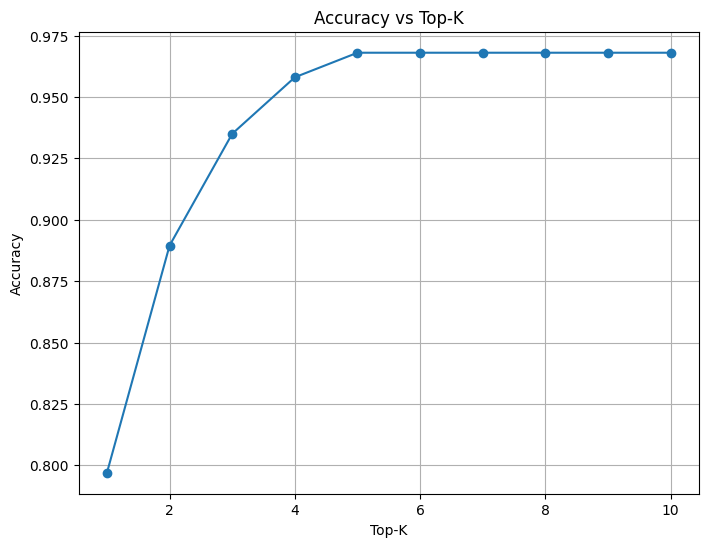

In [23]:
accuracies = []

for k in range(1, 11):
    correct = 0
    for i, positive_index in enumerate(range(len(anchors))):
        if positive_index in indices[i][:k]:
            correct += 1
    accuracies.append(correct / len(anchors))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), accuracies, marker='o')
plt.title("Accuracy vs Top-K")
plt.xlabel("Top-K")
plt.ylabel("Accuracy")
plt.grid()
plt.show()